In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

---

## RNN model

![rnn name classification model](../assets/rnn-name-classification.png)

In [2]:
class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
from utils import ALL_LETTERS, N_LETTERS
from utils import (
    load_data,
    letter_to_tensor,
    line_to_tensor,
    random_training_example,
)

category_lines, all_categories = load_data()
n_categories = len(all_categories)

print("n_categories:", n_categories)
print("n_letters:", N_LETTERS)
print("all_categories:", all_categories)

n_categories: 18
n_letters: 57
all_categories: ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']


In [4]:
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

In [5]:
# one step
input_tensor = letter_to_tensor("A")
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
print(f"{output.size()=}")
print(f"{next_hidden.size()=}")

output.size()=torch.Size([1, 18])
next_hidden.size()=torch.Size([1, 128])


In [6]:
# whole sequence/name
input_tensor = line_to_tensor("Albert")
hidden_tensor = rnn.init_hidden()
print(f"{input_tensor.size()=}")

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())

input_tensor.size()=torch.Size([6, 1, 57])
torch.Size([1, 18])
torch.Size([1, 128])


In [8]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]


print(category_from_output(output))

Portuguese


In [12]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [13]:
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    optimizer.zero_grad() # zero the gradient
    loss.backward() # backpropagation (and calculate the gradients)
    optimizer.step() # update the weights (by the gradients calculated in the previous line)

    return output, loss.item()

In [14]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(
        category_lines, all_categories
    )

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i + 1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i + 1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

5000 5.0 2.7521 Cote / Japanese WRONG (French)
10000 10.0 2.4813 Upjohn / Irish WRONG (English)
15000 15.0 0.1248 Eliopoulos / Greek CORRECT
20000 20.0 0.4084 Sabbag / Arabic CORRECT
25000 25.0 2.7203 Hayden / Arabic WRONG (Irish)
30000 30.0 1.2967 Joe / Korean WRONG (Chinese)
35000 35.0 1.8138 Vicario / Portuguese WRONG (Spanish)
40000 40.0 1.2140 Aldana / Italian WRONG (Spanish)
45000 45.0 1.0448 Lauwers / Dutch CORRECT
50000 50.0 1.0870 Cermak / Czech CORRECT
55000 55.00000000000001 0.8190 Montagne / French CORRECT
60000 60.0 1.4052 Tuma / Japanese WRONG (Arabic)
65000 65.0 0.5112 Szweda / Polish CORRECT
70000 70.0 1.1966 Demetrious / Portuguese WRONG (Greek)
75000 75.0 1.1158 Kolijn / Dutch CORRECT
80000 80.0 2.7371 Marquering / Italian WRONG (Dutch)
85000 85.0 0.2691 Rooiakker / Dutch CORRECT
90000 90.0 0.5818 Waclauska / Czech CORRECT
95000 95.0 0.9584 Madden / Irish CORRECT
100000 100.0 0.4609 Dobrolensky / Russian CORRECT


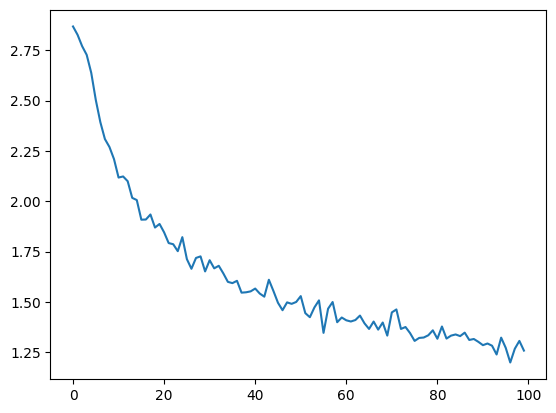

In [15]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [17]:
def predict(input_line):
    print(f"\n> {input_line}")
    rnn.eval()
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)

        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        guess = category_from_output(output)
        print(guess)

In [19]:
while True:
    sentence = input("Input:")
    if sentence == "quit":
        break

    predict(sentence)


> Deependu
French

> Abakumov
Russian

> Brzezicki
Polish

> Filipowski
Polish

> Fujimoto
Japanese

> Abdank-Kossovsky
Russian

> Aswad
Arabic

> Foong
Italian

> Fei
Chinese

> Baumgartner
English
